# General Attention Mechanism
In the modern deep learning era, the attention mechanism has become one of the biggest breakthroughs in processing sequential data, particularly in natural language processing (NLP). The basic concept is simple yet revolutionary: each element in a sequence can "pay attention" to other elements, then weigh the relevant information to produce a richer representation. This mechanism overcomes the limitations of traditional approaches such as RNNs, which struggle to capture long-range dependencies.

This notebook is designed to provide readers with an intuitive understanding of this mechanism. It begins by constructing representations of Query (Q), Key (K), and Value (V), and then directly examines how attention weights are calculated and applied. Heatmap visualizations, including interactive versions, are used to demonstrate that attention is not always static. Before training, its distribution is random; after training, the pattern becomes directed and meaningful.

The urgency is clear: without a deep understanding of attention, we will simply use Transformers or similar models as "black boxes" without truly understanding how information is transferred and processed within them. By mastering this mechanism, we can not only understand the model but also adapt it to various challenges, from machine translation and sentiment analysis to processing non-text data such as images and time series. The advantages of attention include its ability to capture relationships between elements without order constraints, ease of computational parallelization, and flexibility for use in various domains.

# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create a softmax function
Converts numbers into probabilities that total 1, while preventing the calculated result from being too large or too small so the computer can still calculate it accurately.

In [2]:
def softmax(x):
    """Numerically stable softmax, row-by-row (axis=-1)."""
    x = np.asarray(x, dtype=np.float64)
    x_shift = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x_shift)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Attention Heatmap Visualization
Displays a heatmap that illustrates the attention weights of each query token relative to the key token, allowing for visual representation of the relationships between words.

In [3]:
def heatmap_attention(weights, xlabels, ylabels, title):
    """Displaying attention heatmap using matplotlib (without seaborn)."""
    fig = plt.figure(figsize=(6.5, 5.5))
    plt.imshow(weights, aspect='auto')
    plt.title(title)
    plt.xlabel('Key (K)')
    plt.ylabel('Query (Q)')
    plt.xticks(ticks=np.arange(len(xlabels)), labels=xlabels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(ylabels)), labels=ylabels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Token Representation: One-Hot ➜ Q, K, V Projections
* One-hot is the simplest way to represent words/tokens in vector form.
* While it doesn't convey semantic meaning, it makes it easier to understand the initial Transformer process because each word is represented by a distinct vector.
* The Q, K, and V projections are linear transformations of these representations to prepare for attention calculations.

## Definition of token and one-hot
* A token is a basic unit of text (word, subword, or character) that serves as input to the model.
* One-hot represents each token as a vector of length n (the number of unique tokens), with one element equal to 1 and the rest equal to 0.
* The goal is to ensure the identity of each token is preserved before being projected into a more meaningful vector space.

In [24]:
tokens = ["A", "B", "C", "D"]
I = np.eye(len(tokens))  # identity matrix -> one-hot for 4 tokens

In [25]:
print("Tokens:", tokens)
print("\nOne-hot (I):\n", I)

Tokens: ['A', 'B', 'C', 'D']

One-hot (I):
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Random weight matrix
* Random weights are used instead of the training weights to simplify the simulation.
* This matrix transforms the one-hot representation into Q, K, and V vectors.
* Although random, it illustrates how the weights act as a "bridge" between the initial representation and the attention calculation.

In [6]:
np.random.seed(42)
W_Q = np.random.randint(0, 3, size=(4, 4))  # 4x4 for easy navigation
W_K = np.random.randint(0, 3, size=(4, 4))
W_V = np.random.randint(0, 3, size=(4, 4))

In [7]:
print("\nW_Q:\n", W_Q)
print("\nW_K:\n", W_K)
print("\nW_V:\n", W_V)


W_Q:
 [[2 0 2 2]
 [0 0 2 1]
 [2 2 2 2]
 [0 2 1 0]]

W_K:
 [[1 1 1 1]
 [0 0 1 1]
 [0 0 0 2]
 [2 2 1 2]]

W_V:
 [[1 1 2 1]
 [2 2 0 2]
 [0 2 2 0]
 [0 2 1 0]]


## Projection Q, K, V
* Projection is a matrix multiplication operation that produces three vectors: Query (Q), Key (K), and Value (V).
* Q represents what a token is searching for.
* K stores what other tokens have.
* V contains the information to be shared.

In [8]:
Q = I @ W_Q
K = I @ W_K
V = I @ W_V

In [9]:
print("\nQ = I @ W_Q:\n", Q)
print("\nK = I @ W_K:\n", K)
print("\nV = I @ W_V:\n", V)


Q = I @ W_Q:
 [[2. 0. 2. 2.]
 [0. 0. 2. 1.]
 [2. 2. 2. 2.]
 [0. 2. 1. 0.]]

K = I @ W_K:
 [[1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 2.]
 [2. 2. 1. 2.]]

V = I @ W_V:
 [[1. 1. 2. 1.]
 [2. 2. 0. 2.]
 [0. 2. 2. 0.]
 [0. 2. 1. 0.]]


# Scaled Dot-Product Attention
* This is the core mechanism that measures how relevant one token is to another.
* It relies on the similarity of Q to K, then uses those weights to aggregate the values of V.

## Similarity score Q vs. K
* Calculated by the dot product of Q and K.T.
* The higher the score, the higher the match between the two tokens.
* This represents the level of attention that should be given.

In [10]:
scores = Q @ K.T

In [11]:
print("Scores (Q @ K.T):\n", scores)

Scores (Q @ K.T):
 [[ 6.  4.  4. 10.]
 [ 3.  3.  2.  4.]
 [ 8.  4.  4. 14.]
 [ 3.  1.  0.  5.]]


### Interpretation
* Large numbers indicate a query is more similar to that key. These are raw scores before scaling and softmax.
* Q(A) is the highest relative to K(D) with a value of 10.
* Q(B) is the highest relative to K(D) with a value of 4.
* Q(C) is the highest relative to K(D) with a value of 14.
* Q(D) is the highest relative to K(D) with a value of 5, and is 0 to K(C), indicating it is almost unrelated.
* Column D has the highest total score compared to other columns, so it will likely dominate attention after softmax.
* There is potential for attention collapse to token D.
* A value of 0 in row Q(D) of column K(C) will remain very small after softmax, so D will not extract much information from C.

## Scale by \sqrt(d_k)
* Scores are divided by the square root of the dimension K(sqrt(d_k)) to prevent too large values that can make the softmax too “sharp” and numerically unstable.

In [12]:
d_k = K.shape[1]
scaled_scores = scores / np.sqrt(d_k)

In [13]:
print("\nScaled Scores (scores / sqrt(d_k)):\n", scaled_scores)


Scaled Scores (scores / sqrt(d_k)):
 [[3.  2.  2.  5. ]
 [1.5 1.5 1.  2. ]
 [4.  2.  2.  7. ]
 [1.5 0.5 0.  2.5]]


## Softmax ➜ attention weights
* Softmax converts scores into a probability distribution so that the attention weights between tokens are always between 0–1 and sum to 1.
* These weights determine the portion of information extracted from each other token.

In [14]:
weights = softmax(scaled_scores)

In [15]:
print("\nAttention Weights (softmax):\n", weights)


Attention Weights (softmax):
 [[0.10959126 0.04031637 0.04031637 0.80977599]
 [0.23500371 0.23500371 0.14253696 0.38745562]
 [0.04682479 0.00633705 0.00633705 0.94050111]
 [0.23205671 0.08536889 0.05177885 0.63079554]]


### Interpretation
* The values in each row represent the probability of attention for a query across all keys.
* Q(A) focuses 80.98% on K(D), with the remainder being divided slightly among K(A), K(B), and K(C).
* Q(B) has a more balanced attention distribution, but still tends to favor K(D) (38.75%).
* Q(C) is highly focused on K(D) (94.05%), almost ignoring other tokens.
* Q(D) focuses the majority of attention on K(D) (63.08%), with the remainder being moderately focused on K(A) and K(B).
* Token D is the primary focus of attention for almost all queries.
* This distribution shows an attention bias pattern centered on a particular token.

## Weighted sum over V
* Attention weights are used to combine the values of V, resulting in a final context vector that already “takes into account” the relationships between tokens.

In [16]:
attention_output = weights @ V

In [17]:
print("\nAttention Output (weights @ V):\n", attention_output)


Attention Output (weights @ V):
 [[0.19022401 1.89040874 1.10959126 0.19022401]
 [0.70501114 1.76499629 1.14253696 0.70501114]
 [0.05949889 1.95317521 1.04682479 0.05949889]
 [0.4027945  1.76794329 1.19846667 0.4027945 ]]


### Interpretation
* Each row is the final representation per query after combining the rows of V according to their attention weights.
* The pattern of the highest values is consistent in the 2nd and 3rd columns, indicating that the Value dimension is most "taken" by the majority of queries.
* Q(A) is heavily influenced by the V of token D, so its output is closer to a combination dominated by V[D].
* Q(B) is more mixed because its attention distribution is more balanced; contributions from V[A], V[B], and V[D] are visible.
* Q(C) almost entirely follows V[D] because its weight to K(D) is ~94%; its output is closest to row V[D].
* Q(D) remains dominated by V[D] but still takes portions of V[A] and V[B] according to their weights.
* The values in the 1st and 4th columns are identical in each row, indicating that columns 1 and 4 in the V matrix are identical or very similar.
* In general, the output is a convex combination (weighted sum) of the rows of V; the dominance of attention to D makes the entire output lean towards the information carried by token D.

# Heatmap Attention Weights
* This visualization shows the attention weight between each query and key.
* Darker/lighter colors indicate different levels of attention, so we can see which tokens influence others the most.

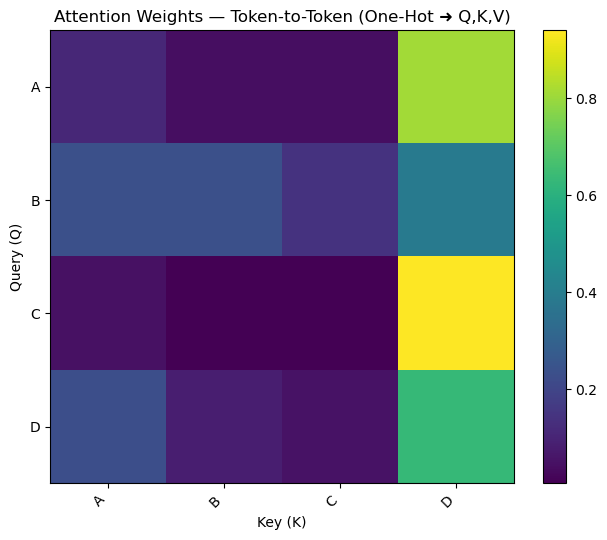

In [18]:
heatmap_attention(
    weights,
    xlabels=tokens,
    ylabels=tokens,
    title="Attention Weights — Token-to-Token (One-Hot ➜ Q,K,V)"
)

### Interpretation
* The vertical axis represents the query, the horizontal axis represents the key.
* Lighter colors indicate higher attention weights, darker colors indicate lower attention weights.
* Q(A) strongly favors K(D) (bright green), with low attention to other tokens.
* Q(B) is more balanced, with medium intensity toward all keys, but still tends toward K(D).
* Q(C) pays almost all attention to K(D) (very bright yellow), with other tokens almost ignored.
* Q(D) is dominant toward K(D) but still gives some attention to K(A) and K(B).
* Token D is the primary focus of attention for almost all queries, which aligns with the previous interpretation of the attention weights matrix.
* This pattern illustrates "single-focus attention" that potentially ignores information from tokens other than D.

# Token Representation: Random Embedding ➜ Q, K, V
* This approach uses a randomly generated, fixed-dimensional embedding vector for each token, rather than one-hot.
* This reflects the way modern NLP models represent words, where embeddings can contain semantic information and relationships between words.

## Random embedding
* The `np.random.seed(7)` code ensures consistent random embedding results every time it is run.
* The embedding matrix E is generated with random values, representing each token in a richer numerical dimension than one-hot.

In [4]:
np.random.seed(7)
n_tokens = 6
d_embed = 4

tokens2 = ["The", "cat", "sat", "on", "the", "mat"]
E = np.random.rand(n_tokens, d_embed)  # embedding acak

In [5]:
print("Tokens:", tokens2)
print("\nRandom embedding: \n", E)

Tokens: ['The', 'cat', 'sat', 'on', 'the', 'mat']

Random embedding: 
 [[0.07630829 0.77991879 0.43840923 0.72346518]
 [0.97798951 0.53849587 0.50112046 0.07205113]
 [0.26843898 0.4998825  0.67923    0.80373904]
 [0.38094113 0.06593635 0.2881456  0.90959353]
 [0.21338535 0.45212396 0.93120602 0.02489923]
 [0.60054892 0.9501295  0.23030288 0.54848992]]


## Random weight matrices
* Three weight matrices (W_Q, W_K, W_V) are randomly initialized.
* Each matrix projects the initial embedding into a different vector space to generate the Query, Key, and Value.

In [6]:
W_Q2 = np.random.randn(d_embed, d_embed)
W_K2 = np.random.randn(d_embed, d_embed)
W_V2 = np.random.randn(d_embed, d_embed)

In [7]:
print("\nW_Q2:\n", W_Q2)
print("\nW_K2:\n", W_K2)
print("\nW_V2:\n", W_V2)


W_Q2:
 [[ 1.65069969  0.15433554 -0.38713994  2.02907222]
 [-0.04538603 -1.4506787  -0.40522786 -2.2883151 ]
 [ 1.04939655 -0.41647432 -0.74255353  1.07247013]
 [-1.65107559  0.53542936 -2.0644148  -0.66215934]]

W_K2:
 [[-1.20421985  1.46197563  1.76616088 -0.32941375]
 [ 0.84073324 -0.1799864   0.56806189 -0.7528372 ]
 [-1.7083392  -1.80309866  0.38312185  2.24759505]
 [ 0.26941163 -0.52460462  1.91201886  0.23730185]]

W_V2:
 [[ 0.10143399  0.25257774 -0.1323772  -0.30947634]
 [-1.43496347  0.50162412 -0.09477545  1.19308592]
 [-0.36881847 -1.90636988 -0.09961063  1.6995373 ]
 [-0.38342312 -0.88985686 -1.19359192 -1.05001681]]


## Projection of Q, K, V
* Embedding E is multiplied by each weight matrix to produce Q, K, and V.
* Q is used to find relevant information.
* K acts as an index or marker.
* V contains the information to be retrieved.

In [9]:
Q2 = E @ W_Q2
K2 = E @ W_K2
V2 = E @ W_V2

In [10]:
print("\nQ2 = E @ W_Q2:\n", Q2)
print("\nK2 = E @ W_K2:\n", K2)
print("\nV2 = E @ W_V2:\n", V2)


Q2 = E @ W_Q2:
 [[-0.64386591 -0.91485619 -2.16466135 -1.63873334]
 [ 1.99683901 -0.80037147 -1.11768452  1.24189052]
 [-0.19382783 -0.5362756  -2.47010516 -0.40295602]
 [-0.57360185  0.33015813 -2.26593865  0.32880563]
 [ 1.2678089  -0.99744527 -1.00869586  0.38057559]
 [ 0.28428404 -1.08788422 -1.92083834 -1.07183332]]

K2 = E @ W_K2:
 [[ 0.00976995 -1.19884219  2.12905808  0.54475717]
 [-1.56165532  0.3915069   2.36293912  0.41585083]
 [-0.8468103  -1.34388471  2.55506267  1.2526051 ]
 [-0.65049734 -0.4516729   2.55981411  0.68835626]
 [-1.46095484 -1.46153055  1.03808042  1.68821487]
 [-0.17005334  0.00397833  2.7373555  -0.26533662]]

V2 = E @ W_V2:
 [[-1.55050142 -1.06905075 -0.99121105  0.89233676]
 [-0.88596908 -0.50229526 -0.31641628  1.11582524]
 [-1.24876899 -1.69152147 -1.10990674  0.82376447]
 [-0.51100848 -1.22942762 -1.17106292 -0.50459884]
 [-0.98012976 -1.51668718 -0.19357514  2.02985977]
 [-1.59772872 -0.29882683 -0.84716169  0.76321515]]


## Similarity score Q vs K
* Using the dot product operation Q @ K.T, a score is obtained that measures the closeness or relevance between tokens.

In [11]:
scores2 = Q2 @ K2.T

In [12]:
print("Scores (Q @ K2.T):\n", scores2)

Scores (Q @ K2.T):
 [[-4.41092381 -5.14910749 -5.80883763 -5.83711421 -2.73587727 -5.38477973]
 [-0.7240584  -5.55630451 -1.91549247 -2.94363386 -0.81119266 -3.7317722 ]
 [-4.8374944  -5.91154104 -5.93119028 -6.23208169 -2.17748728 -6.62380936]
 [-5.04660732 -4.19251341 -5.33571416 -5.35004331 -1.44166179 -6.1910674 ]
 [-0.73208489 -4.59561147 -1.8337124  -2.69428963 -0.79902887 -3.08170312]
 [-3.36648632 -5.85441469 -5.02918991 -5.34835045 -2.62881974 -5.02629217]]


## Scale by sqrt(d_k)
* Scores are divided by the square root of the Key dimension (sqrt(d_k)) to prevent excessively large values that could cause the softmax distribution to be too sharp.

In [13]:
scaled_scores2 = scores2 / np.sqrt(K2.shape[1])

In [14]:
print("\nScaled Scores (scores / sqrt(d_k)):\n", scaled_scores2)


Scaled Scores (scores / sqrt(d_k)):
 [[-2.2054619  -2.57455375 -2.90441881 -2.91855711 -1.36793863 -2.69238987]
 [-0.3620292  -2.77815226 -0.95774624 -1.47181693 -0.40559633 -1.8658861 ]
 [-2.4187472  -2.95577052 -2.96559514 -3.11604085 -1.08874364 -3.31190468]
 [-2.52330366 -2.09625671 -2.66785708 -2.67502165 -0.7208309  -3.0955337 ]
 [-0.36604244 -2.29780574 -0.9168562  -1.34714482 -0.39951444 -1.54085156]
 [-1.68324316 -2.92720734 -2.51459495 -2.67417522 -1.31440987 -2.51314608]]


## Softmax ➜ attention weights
* Softmax converts escalated scores into probabilities, indicating how much attention each token gives to other tokens.

In [16]:
weights2 = softmax(scaled_scores2)

In [17]:
print("\nAttention Weights (softmax):\n", weights2)


Attention Weights (softmax):
 [[0.17845229 0.12337512 0.08870927 0.0874639  0.41233848 0.10966095]
 [0.31749028 0.02834141 0.17499024 0.10465398 0.30395513 0.07056895]
 [0.14595119 0.08530635 0.08447235 0.07267363 0.55184973 0.05974675]
 [0.09185895 0.14079448 0.07949554 0.07892802 0.55709015 0.05183286]
 [0.29653963 0.04296636 0.17094932 0.111172   0.28677814 0.09159455]
 [0.2514415  0.07247533 0.10949278 0.09334276 0.36359611 0.10965153]]


## Weighted sum over V
* Probability weights are used to combine the values (V) into a final representation that focuses on the most important information.

In [18]:
out2 = weights2 @ V2

In [19]:
print("\nAttention Output (weights2 @ V):\n", out2)


Attention Output (weights2 @ V):
 [[-1.12082291 -1.16848757 -0.58952555  1.24653016]
 [-1.20004572 -1.26040597 -0.75906827  1.07712036]
 [-1.08084305 -1.28594931 -0.50796212  1.42411608]
 [-1.03560692 -1.26084751 -0.4680132   1.43510427]
 [-1.19556106 -1.22676372 -0.76056433  1.04930664]
 [-1.17006619 -1.18940366 -0.66627672  1.17007272]]


## Summary

In [20]:
print("Random Embedding (E):\n", E)
print("\nAttention Weights (random embedding):\n", weights2)
print("\nAttention Output (weights @ V:\n", out2)

Random Embedding (E):
 [[0.07630829 0.77991879 0.43840923 0.72346518]
 [0.97798951 0.53849587 0.50112046 0.07205113]
 [0.26843898 0.4998825  0.67923    0.80373904]
 [0.38094113 0.06593635 0.2881456  0.90959353]
 [0.21338535 0.45212396 0.93120602 0.02489923]
 [0.60054892 0.9501295  0.23030288 0.54848992]]

Attention Weights (random embedding):
 [[0.17845229 0.12337512 0.08870927 0.0874639  0.41233848 0.10966095]
 [0.31749028 0.02834141 0.17499024 0.10465398 0.30395513 0.07056895]
 [0.14595119 0.08530635 0.08447235 0.07267363 0.55184973 0.05974675]
 [0.09185895 0.14079448 0.07949554 0.07892802 0.55709015 0.05183286]
 [0.29653963 0.04296636 0.17094932 0.111172   0.28677814 0.09159455]
 [0.2514415  0.07247533 0.10949278 0.09334276 0.36359611 0.10965153]]

Attention Output (weights @ V:
 [[-1.12082291 -1.16848757 -0.58952555  1.24653016]
 [-1.20004572 -1.26040597 -0.75906827  1.07712036]
 [-1.08084305 -1.28594931 -0.50796212  1.42411608]
 [-1.03560692 -1.26084751 -0.4680132   1.43510427]
 [

### Interpretation
1. Value Characteristics
    - Values range from -1.28 to 1.43.
    - The fourth dimension (last column) is generally positive and quite large, while the other dimensions tend to be negative.
    - There is slight variation between tokens, but the distribution pattern is relatively consistent.
2. Dominantly Positive Dimension
    - The fourth column (1.24, 1.07, 1.42, etc.) has the largest and consistently positive value → attention likely "pulls" highly important information to this dimension (which can be associated with certain semantic features).
3. Consistently Negative Dimension
    - Columns 1, 2, and 3 are predominantly negative, indicating that after combining the V values, this dimension emphasizes or decreases the contribution of certain features.
4. General Interpretation
    - Dimension 4 has the largest positive value across all tokens, indicating that this feature is most dominant after the attention process.
    - Dimensions 1, 2, and 3 are generally negative, indicating that the contribution of certain features is emphasized or decreased.
    - The difference in values between tokens is relatively small, indicating that the model's attention distribution tends to be even.
    - The representation of each token already contains information from other tokens according to the attention weight, making it more contextual.
    - Consistent value patterns indicate that the model is extracting certain semantic features that are equally important across tokens.

## Heatmap Attention Weights
* Visualizes the distribution of attention between tokens using a color map, helping to understand the model's focus patterns.

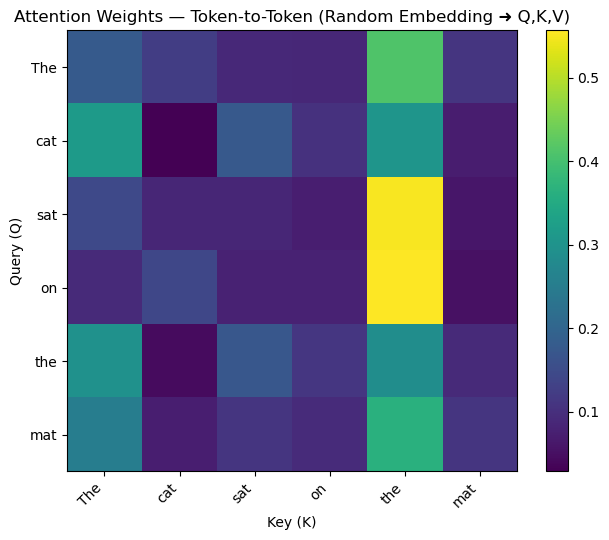

In [21]:
heatmap_attention(
    weights2,
    xlabels=tokens2,
    ylabels=tokens2,
    title="Attention Weights — Token-to-Token (Random Embedding ➜ Q,K,V)"
)

### Interpretation
- The token "the" (lowercase) receives the highest attention out of several other tokens, as indicated by its bright yellow color in its column.
- The tokens "sat" and "on" pay the most attention to the token "the," indicating a dominant relationship to that word.
- The tokens "cat," "the," and "mat" have a more even distribution of attention across several other tokens, with no single, extreme focus.
- The first token "The" (uppercase) tends to receive moderate attention to the token "the" (lowercase), indicating a difference even though they are the same word but in different positions/capitalization.
- The lowest attention scores are generally found on the diagonal other than the dominant token, indicating that the token pays less attention to itself.

## Interactive Heatmap
* The interactive version facilitates direct exploration of attention values, allowing detailed observation of specific token pairs.

In [26]:
try:
    from ipywidgets import interact, IntSlider

    def recompute(seed=0):
        np.random.seed(seed)
        W_Qi = np.random.randint(0, 3, size=(4, 4))
        W_Ki = np.random.randint(0, 3, size=(4, 4))
        W_Vi = np.random.randint(0, 3, size=(4, 4))

        Q_i = I @ W_Qi
        K_i = I @ W_Ki
        V_i = I @ W_Vi

        scores_i = Q_i @ K_i.T
        scaled_i = scores_i / np.sqrt(K_i.shape[1])
        weights_i = softmax(scaled_i)

        heatmap_attention(
            weights_i,
            xlabels=tokens,
            ylabels=tokens,
            title=f"Attention Weights — seed={seed}"
        )

    interact(recompute, seed=IntSlider(min=0, max=50, step=1, value=0));
except Exception as e:
    print("ipywidgets interaction is not available in this environment:", e)

interactive(children=(IntSlider(value=0, description='seed', max=50), Output()), _dom_classes=('widget-interac…

### Interpretation
- The color block pattern changes → indicating which tokens are paying attention to each other.\
This proves that initial attention is entirely determined by the initial weights and has no semantic meaning.
- Sometimes there are dominant tokens → a bright color in one column indicates many tokens are "paying attention" to that token, but this is purely a random number generator, not based on meaning.
- The distribution can be even or concentrated → some seeds produce a nearly even attention pattern (uniform color), while others are more concentrated (bright colors in certain areas).
- The relationship between tokens is inconsistent → for example, in certain seeds, the word "cat" might receive a lot of attention, but not at all in other seeds.
- This means there is no stable knowledge yet.

# Conclusion
The attention mechanism is more than just matrix operations; it is at the heart of modern models' ability to understand context. Seed experiments that generate different attention patterns show that before training, a model's focus is simply a random result of parameter initialization. However, through training, this mechanism evolves into a system capable of selecting important information and ignoring irrelevant ones.

From a practical perspective, this understanding is invaluable. We no longer view attention as a mysterious process, but as a tool we can control and optimize. Its key advantages, capturing long-range relationships, working efficiently in parallel, and being flexible across different types of data, make it a key pillar of many advanced models today. In conclusion, understanding the attention mechanism opens the door to mastering modern architectures like the Transformer and its derivatives.

# Thank You